In [1]:
# === Imports & manual file upload (Colab) ===
import pandas as pd
import numpy as np
from google.colab import files

# 1) Upload CSV from local machine (you'll get a file chooser)
uploaded = files.upload()

# 2) Read the first uploaded file
file_name = list(uploaded.keys())[0]
# GTD is big; ISO-8859-1 avoids encoding errors; low_memory=False for accurate dtypes inference
df = pd.read_csv(file_name, encoding="ISO-8859-1", low_memory=False)

# 3) Initial assessment
print("Shape:", df.shape)
print("Columns (first 25):", df.columns.tolist()[:25])
display(df.head(3))

# Optional: quick statistics for numeric columns
display(df.describe(include=[np.number]).T.head(10))


Saving globalterrorismdb_0718dist.csv to globalterrorismdb_0718dist.csv
Shape: (181691, 135)
Columns (first 25): ['eventid', 'iyear', 'imonth', 'iday', 'approxdate', 'extended', 'resolution', 'country', 'country_txt', 'region', 'region_txt', 'provstate', 'city', 'latitude', 'longitude', 'specificity', 'vicinity', 'location', 'summary', 'crit1', 'crit2', 'crit3', 'doubtterr', 'alternative', 'alternative_txt']


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


,count,mean,std,min,25%,50%,75%,max
eventid,181691.0,2.002705e+11,1.325957e+09,1.970000e+11,1.991021e+11,2.009022e+11,2.014081e+11,2.017123e+11
iyear,181691.0,2.002639e+03,1.325943e+01,1.970000e+03,1.991000e+03,2.009000e+03,2.014000e+03,2.017000e+03
imonth,181691.0,6.467277e+00,3.388303e+00,0.000000e+00,4.000000e+00,6.000000e+00,9.000000e+00,1.200000e+01
iday,181691.0,1.550564e+01,8.814045e+00,0.000000e+00,8.000000e+00,1.500000e+01,2.300000e+01,3.100000e+01
extended,181691.0,4.534622e-02,2.080629e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
country,181691.0,1.319685e+02,1.124145e+02,4.000000e+00,7.800000e+01,9.800000e+01,1.600000e+02,1.004000e+03
region,181691.0,7.160938e+00,2.933408e+00,1.000000e+00,5.000000e+00,6.000000e+00,1.000000e+01,1.200000e+01
latitude,177135.0,2.349834e+01,1.856924e+01,-5.315461e+01,1.151005e+01,3.146746e+01,3.468509e+01,7.463355e+01
longitude,177134.0,-4.586957e+02,2.047790e+05,-8.618590e+07,4.545640e+00,4.324651e+01,6.871033e+01,1.793667e+02
specificity,181685.0,1.451452e+00,9.954295e-01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.000000e+00


In [2]:
# Overview of dtypes and missingness
print("dtypes overview:")
display(df.dtypes.head(20))

missing_ratio = df.isna().mean().sort_values(ascending=False)
print("Top 20 columns by missing ratio:")
display(missing_ratio.head(20))


dtypes overview:


,0
eventid,int64
iyear,int64
imonth,int64
iday,int64
approxdate,object
extended,int64
resolution,object
country,int64
country_txt,object
region,int64


Top 20 columns by missing ratio:


,0
gsubname3,0.999890
weapsubtype4,0.999615
weapsubtype4_txt,0.999615
weaptype4_txt,0.999598
weaptype4,0.999598
claimmode3,0.999268
claimmode3_txt,0.999268
gsubname2,0.999119
claim3,0.998250
guncertain3,0.998239


In [3]:
# 1) Drop columns with >90% missing values (tune if needed)
threshold = 0.90
cols_to_drop = missing_ratio[missing_ratio > threshold].index.tolist()
df_clean = df.drop(columns=cols_to_drop)
print(f"Dropped {len(cols_to_drop)} columns with >{int(threshold*100)}% missing.")

# 2) Ensure date components are numeric
for c in ("iyear", "imonth", "iday"):
    if c in df_clean.columns:
        df_clean[c] = pd.to_numeric(df_clean[c], errors="coerce")

# 3) Build a safe datetime (month/day may be 0 → coerce to 1)
if all(c in df_clean.columns for c in ("iyear", "imonth", "iday")):
    df_clean["date"] = pd.to_datetime(
        {
            "year": df_clean["iyear"],
            "month": df_clean["imonth"].replace(0, 1),
            "day": df_clean["iday"].replace(0, 1),
        },
        errors="coerce",
    )

# 4) Fill categorical NaNs with 'Unknown'
cat_cols = df_clean.select_dtypes(include="object").columns
df_clean[cat_cols] = df_clean[cat_cols].fillna("Unknown")

# 5) Fill numeric NaNs with median (per-column)
num_cols = df_clean.select_dtypes(include=[np.number]).columns
for c in num_cols:
    if df_clean[c].isna().any():
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())

print("Cleaned shape:", df_clean.shape)
display(df_clean.head(3))


Dropped 62 columns with >90% missing.
Cleaned shape: (181691, 74)


,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,provstate,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,date
0,197000000001,1970,7,2,0,58,Dominican Republic,2,Central America & Caribbean,Unknown,...,Unknown,Unknown,Unknown,PGIS,0,0,0,0,Unknown,1970-07-02
1,197000000002,1970,0,0,0,130,Mexico,1,North America,Federal,...,Unknown,Unknown,Unknown,PGIS,0,1,1,1,Unknown,1970-01-01
2,197001000001,1970,1,0,0,160,Philippines,5,Southeast Asia,Tarlac,...,Unknown,Unknown,Unknown,PGIS,-9,-9,1,1,Unknown,1970-01-01


In [4]:
from sklearn.preprocessing import StandardScaler

# Choose categorical columns for one-hot encoding (adjust to your analysis needs)
categorical_to_encode = [c for c in ["region_txt", "country_txt", "attacktype1_txt"] if c in df_clean.columns]

# One-hot using pandas.get_dummies (drop_first avoids multicollinearity)
df_encoded = pd.get_dummies(df_clean, columns=categorical_to_encode, drop_first=True)

# Choose numeric columns to scale (adjust as needed)
numeric_to_scale = [c for c in ["nkill", "nwound"] if c in df_encoded.columns]

scaler = StandardScaler()
if numeric_to_scale:
    df_encoded[numeric_to_scale] = scaler.fit_transform(df_encoded[numeric_to_scale])

print("Encoded & scaled shape:", df_encoded.shape)
display(df_encoded.head(3))


Encoded & scaled shape: (181691, 294)


,eventid,iyear,imonth,iday,extended,country,region,provstate,city,latitude,...,country_txt_Zambia,country_txt_Zimbabwe,attacktype1_txt_Assassination,attacktype1_txt_Bombing/Explosion,attacktype1_txt_Facility/Infrastructure Attack,attacktype1_txt_Hijacking,attacktype1_txt_Hostage Taking (Barricade Incident),attacktype1_txt_Hostage Taking (Kidnapping),attacktype1_txt_Unarmed Assault,attacktype1_txt_Unknown
0,197000000001,1970,7,2,0,58,2,Unknown,Santo Domingo,18.456792,...,False,False,True,False,False,False,False,False,False,False
1,197000000002,1970,0,0,0,130,1,Federal,Mexico city,19.371887,...,False,False,False,False,False,False,False,True,False,False
2,197001000001,1970,1,0,0,160,5,Tarlac,Unknown,15.478598,...,False,False,True,False,False,False,False,False,False,False


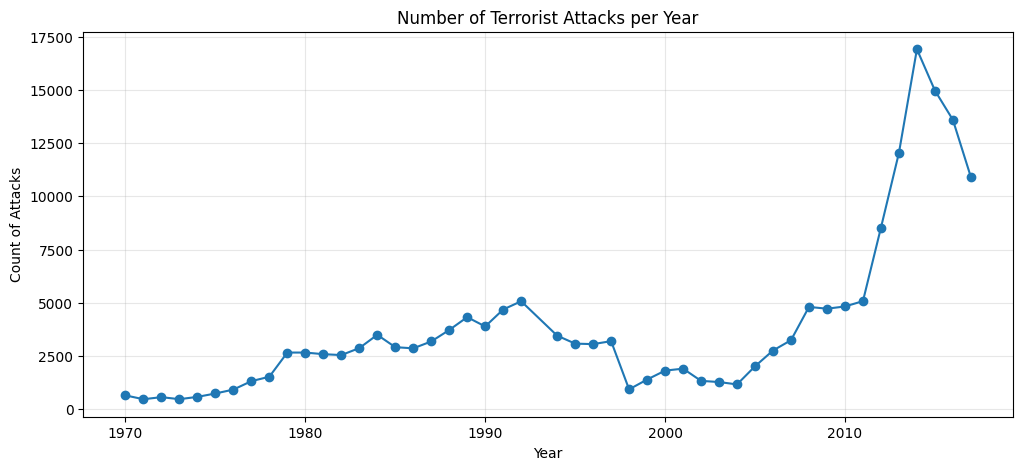

In [5]:
import matplotlib.pyplot as plt

# Number of attacks per year
if "iyear" in df_clean.columns:
    attacks_per_year = df_clean.groupby("iyear").size()

    plt.figure(figsize=(12, 5))
    plt.plot(attacks_per_year.index, attacks_per_year.values, marker="o")
    plt.title("Number of Terrorist Attacks per Year")
    plt.xlabel("Year")
    plt.ylabel("Count of Attacks")
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("Column 'iyear' not found.")


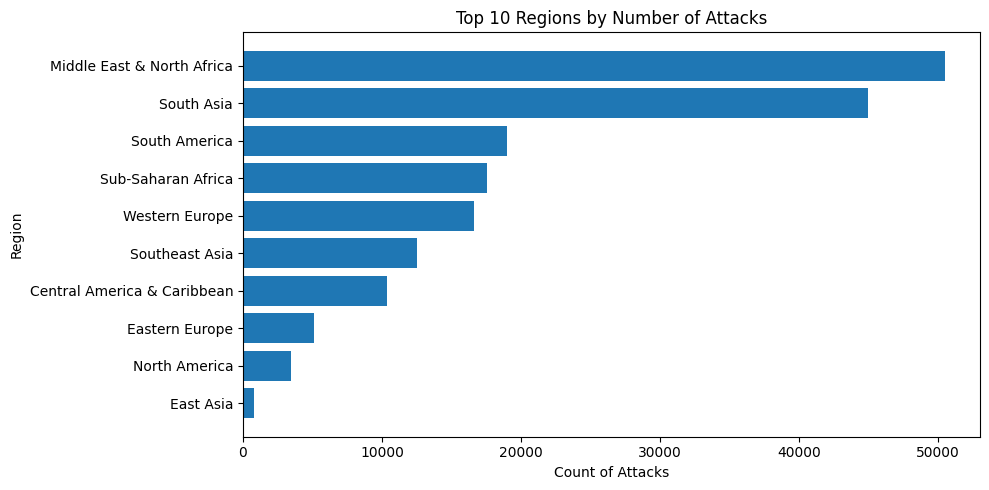

In [6]:
if "region_txt" in df_clean.columns:
    top_regions = df_clean["region_txt"].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    plt.barh(top_regions.index[::-1], top_regions.values[::-1])
    plt.title("Top 10 Regions by Number of Attacks")
    plt.xlabel("Count of Attacks")
    plt.ylabel("Region")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'region_txt' not found.")


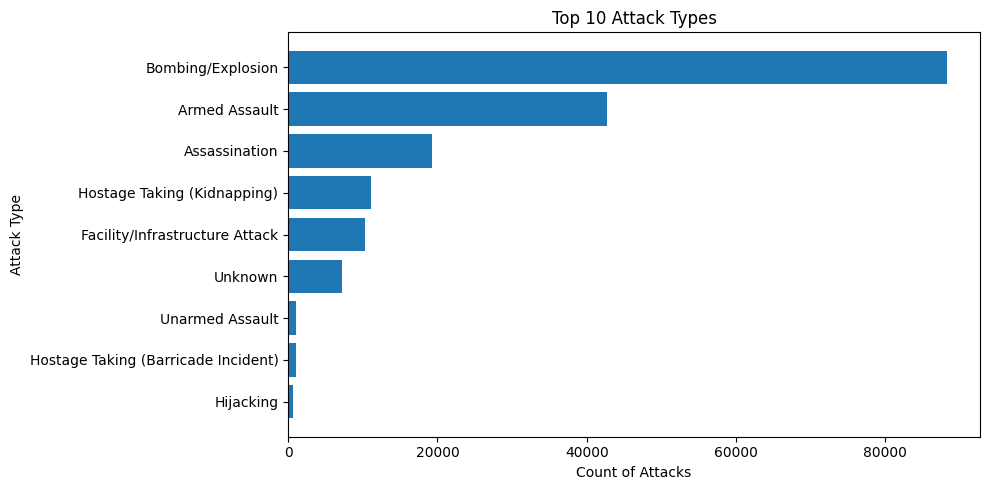

In [7]:
if "attacktype1_txt" in df_clean.columns:
    top_attack_types = df_clean["attacktype1_txt"].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    plt.barh(top_attack_types.index[::-1], top_attack_types.values[::-1])
    plt.title("Top 10 Attack Types")
    plt.xlabel("Count of Attacks")
    plt.ylabel("Attack Type")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'attacktype1_txt' not found.")


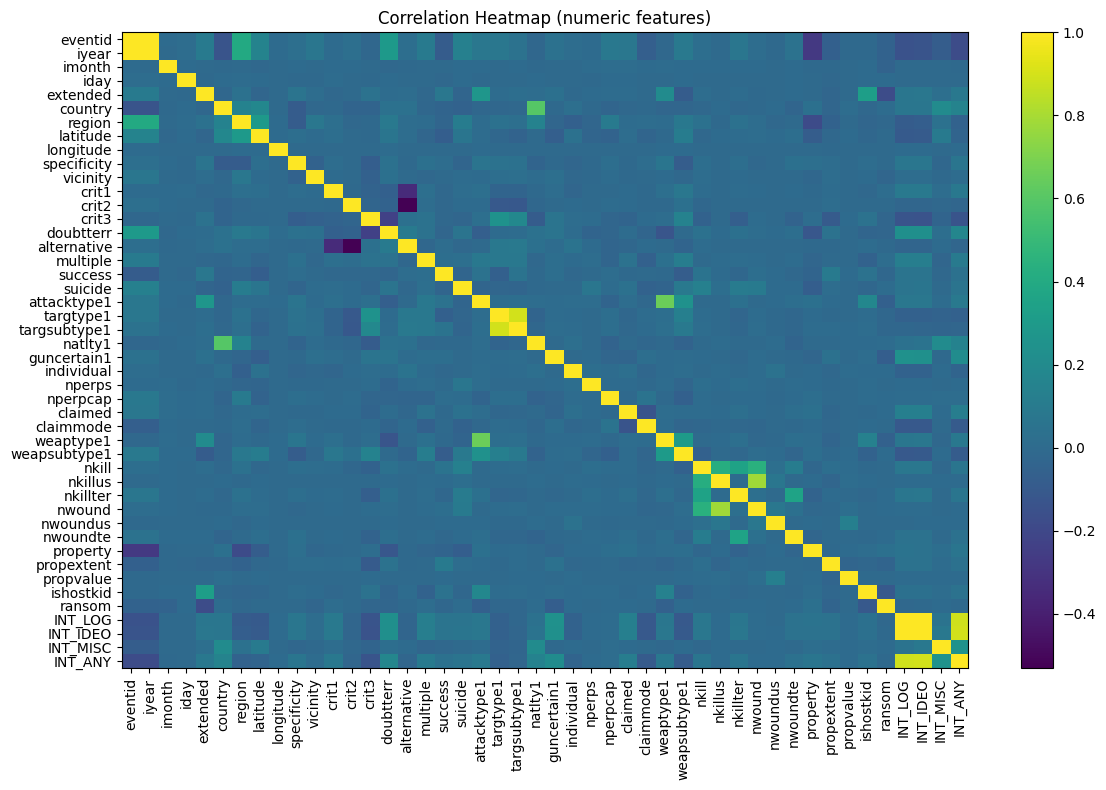

In [8]:
# Build a numeric-only correlation heatmap
num_cols_all = df_encoded.select_dtypes(include=[np.number]).columns
if len(num_cols_all) > 1:
    corr = df_encoded[num_cols_all].corr()

    plt.figure(figsize=(12, 8))
    plt.imshow(corr, aspect="auto")
    plt.colorbar()
    plt.title("Correlation Heatmap (numeric features)")
    plt.xticks(range(len(num_cols_all)), num_cols_all, rotation=90)
    plt.yticks(range(len(num_cols_all)), num_cols_all)
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns to compute correlation heatmap.")


In [9]:
# Save cleaned & encoded datasets
df_clean.to_csv("gtd_clean.csv", index=False, encoding="utf-8-sig")
df_encoded.to_csv("gtd_encoded.csv", index=False, encoding="utf-8-sig")
print("Saved: gtd_clean.csv, gtd_encoded.csv")


Saved: gtd_clean.csv, gtd_encoded.csv
